In [2]:
import os
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'pandas'

In [3]:
DATASET_PATH = '../../dataset/COL774_mammography/'
train_dataset = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'), na_values=['?'])

train_dataset.dropna(axis=0, inplace=True)
train_dataset = train_dataset.astype('int64')
train_dataset.info()
# pd.Series({c: train_dataset[c].unique() for c in train_dataset})


NameError: name 'pd' is not defined

In [3]:
def printAccuracy(model, X, y, X_test, y_test, X_val, y_val):
    print('Training Accuracy: ', model.score(X, y))
    print('Testing Accuracy: ', model.score(X_test, y_test))
    print('Validation Accuracy: ', model.score(X_val, y_val))

In [4]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt


X, y = train_dataset.iloc[:, 1:-1], train_dataset.iloc[:, -1]
model = DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier()

In [5]:
test_dataset = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'), na_values=['?'])
test_dataset.dropna(axis=0, inplace=True)
test_dataset = test_dataset.astype('int64')

val_dataset = pd.read_csv(os.path.join(DATASET_PATH, 'val.csv'), na_values=['?'])
val_dataset.dropna(axis=0, inplace=True)
val_dataset = val_dataset.astype('int64')

X_test, y_test = test_dataset.iloc[:, 1:-1], test_dataset.iloc[:, -1]
X_val, y_val = val_dataset.iloc[:, 1:-1], val_dataset.iloc[:, -1] 

In [6]:
printAccuracy(model, X, y, X_test, y_test, X_val, y_val)

Training Accuracy:  0.9252747252747253
Testing Accuracy:  0.6877470355731226
Validation Accuracy:  0.7603305785123967


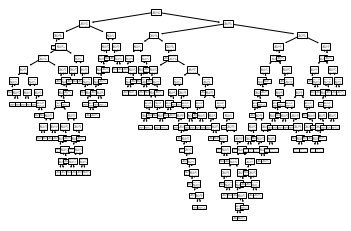

In [7]:
plot_tree(model)
plt.show()

In [8]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

params = {
    'max_depth': [4, 5, 6, 8, 10, 12, 15, 18, 20],
    'min_samples_split': [2, 3, 4, 5, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
cv = np.concatenate((-1*np.ones((X.shape[0], 1)), np.zeros((X_val.shape[0], 1))), axis=0)
cv = PredefinedSplit(cv)
sh = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params, cv=cv, scoring='accuracy', n_jobs=4, refit=True, error_score='raise')

X_cv = pd.concat([X, X_val])
y_cv = pd.concat([y, y_val])

sh.fit(X_cv, y_cv)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise', estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'max_depth': [4, 5, 6, 8, 10, 12, 15, 18, 20],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 8, 10]},
             scoring='accuracy')

In [9]:
print(sh.best_params_)
printAccuracy(sh, X, y, X_test, y_test, X_val, y_val)

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training Accuracy:  0.8285714285714286
Testing Accuracy:  0.758893280632411
Validation Accuracy:  0.8925619834710744


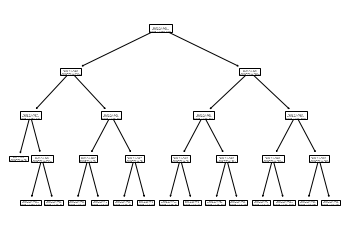

In [10]:
plot_tree(sh.best_estimator_)
plt.show()

In [11]:
model = DecisionTreeClassifier(max_depth=10, min_samples_split=4, min_samples_leaf=2)
model.fit(X, y)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=4)

In [12]:
printAccuracy(model, X, y, X_test, y_test, X_val, y_val)

Training Accuracy:  0.8637362637362638
Testing Accuracy:  0.7035573122529645
Validation Accuracy:  0.8099173553719008


In [13]:
ccp_path = DecisionTreeClassifier(random_state=0).cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

print(ccp_alphas.shape)

(63,)


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

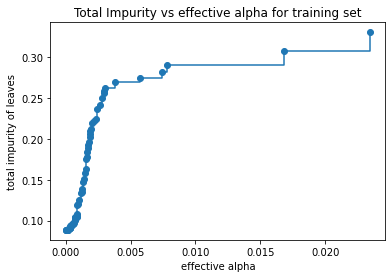

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [15]:
ccp_models = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    ccp_models.append(clf)

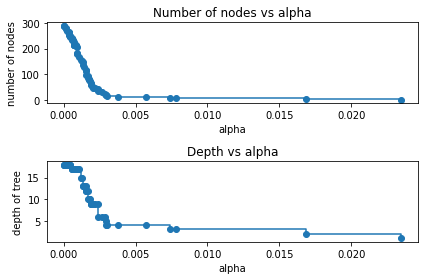

In [16]:
ccp_models = ccp_models[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [model.tree_.node_count for model in ccp_models]
depth = [model.tree_.max_depth for model in ccp_models]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

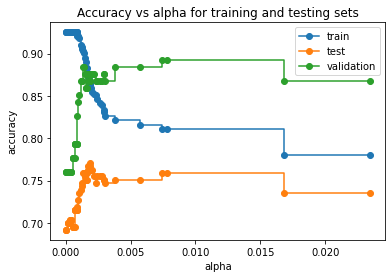

In [17]:
train_scores = [model.score(X, y) for model in ccp_models]
test_scores = [model.score(X_test, y_test) for model in ccp_models]
val_scores = [model.score(X_val, y_val) for model in ccp_models]

fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs alpha for training and testing sets')
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.plot(ccp_alphas, val_scores, marker='o', label='validation', drawstyle='steps-post')
ax.legend()
plt.show()

In [18]:
ccp_model = ccp_models[np.argmax(val_scores)]
printAccuracy(ccp_model, X, y, X_test, y_test, X_val, y_val)

Training Accuracy:  0.810989010989011
Testing Accuracy:  0.758893280632411
Validation Accuracy:  0.8925619834710744


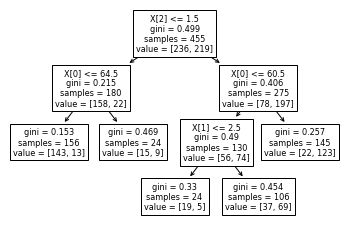

In [27]:
plot_tree(ccp_model)
plt.savefig('1_c_dtree_ccp.png', dpi=300)

# Part d: Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

def oob_scorer(estimator, X, y):
    return estimator.oob_score_

params = {
    'n_estimators': [10, 50, 100, 120, 150, 180, 200],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 4, 6, 8, 10, 12],
}
rf_model = GridSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=0), param_grid=params, cv=cv, scoring='accuracy', n_jobs=4, refit=True, error_score='raise')
rf_model.fit(X_cv, y_cv)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise',
             estimator=RandomForestClassifier(oob_score=True, random_state=0),
             n_jobs=4,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 4, 6, 8, 10, 12],
                         'n_estimators': [10, 50, 100, 120, 150, 180, 200]},
             scoring='accuracy')

In [20]:
print(rf_model.best_params_)
print('Best OOB Accuracy: ', rf_model.best_score_)
# print('Testing Accuracy: ', rf_model.score(X_test, y_test))
# print('Validation Accuracy: ', rf_model.score(X_val, y_val))
printAccuracy(rf_model, X, y, X_test, y_test, X_val, y_val)

{'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}
Best OOB Accuracy:  0.8842975206611571
Training Accuracy:  0.865934065934066
Testing Accuracy:  0.766798418972332
Validation Accuracy:  0.9173553719008265


In [21]:
print(rf_model.best_estimator_.oob_score_)

0.8107638888888888


In [22]:
from sklearn.impute import SimpleImputer

train_dataset = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'), na_values=['?'])
test_dataset = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'), na_values=['?'])
val_dataset = pd.read_csv(os.path.join(DATASET_PATH, 'val.csv'), na_values=['?'])

imp_median = SimpleImputer(strategy='median', missing_values=pd.NA)
imp_mode = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)

imp_median.fit(train_dataset)
imp_mode.fit(train_dataset)

train_dataset = imp_median.transform(train_dataset)
test_dataset = imp_median.transform(test_dataset)
val_dataset = imp_median.transform(val_dataset)

X, y = train_dataset[:, 1:-1], train_dataset[:, -1]
X_test, y_test = test_dataset[:, 1:-1], test_dataset[:, -1]
X_val, y_val = val_dataset[:, 1:-1], val_dataset[:, -1]

model = DecisionTreeClassifier(max_depth=10, min_samples_split=4, min_samples_leaf=2)
model.fit(X, y)

printAccuracy(model, X, y, X_test, y_test, X_val, y_val)

# rf_model.fit(X, y)
# printAccuracy(rf_model, X, y, X_test, y_test, X_val, y_val)

Training Accuracy:  0.8603351955307262
Testing Accuracy:  0.7395833333333334
Validation Accuracy:  0.7777777777777778


In [26]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
y_test = le.transform(y_test)
y_val = le.transform(y_val)


params = {
    'n_estimators': [10, 20, 30, 40, 50],
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
}

cv = np.concatenate((-1*np.ones((X.shape[0], 1)), np.zeros((X_val.shape[0], 1))), axis=0)
cv = PredefinedSplit(cv)
xgb_model = GridSearchCV(estimator=XGBClassifier(random_state=0, n_jobs=-1), param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1, refit=True, error_score='raise')

X_cv = np.concatenate([X, X_val], axis=0)
y_cv = np.concatenate([y, y_val], axis=0)
xgb_model.fit(X_cv, y_cv)

printAccuracy(xgb_model, X, y, X_test, y_test, X_val, y_val)
print(xgb_model.best_params_)


Training Accuracy:  0.8305400372439479
Testing Accuracy:  0.7604166666666666
Validation Accuracy:  0.8740740740740741
{'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}
